#### Import libraries

In [2]:
import os 
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
from scipy.stats import gaussian_kde

#### Load input data

In [3]:
epoch = 169
mode = 'val'  # 'train', 'val', 'test'
model = 'Full_Images_200_epochs'

path_dir_input = os.path.join(os.getcwd(), '..', 'data', 'ERA5', 'preprocessed_separate', mode)
path_dir_target = os.path.join(os.getcwd(), '..', 'data', 'CERRA', 'preprocessed_separate', mode)

path_dir_output = os.path.join(os.getcwd(), '..', 'AirPollution_Run', 'Full_Images_200_epochs', 'output', 'data', 'valid')

print('Loading input data')
ds_input = xr.open_dataset(os.path.join(path_dir_input, f'{mode}_input_data_cams_global_daily_avg.nc'))
ds_target = xr.open_dataset(os.path.join(path_dir_target, f'{mode}_target_data_cams_europe_regional_daily_avg.nc'))
ds_output = xr.open_dataset(os.path.join(path_dir_output, f'reconstructed_y_hat_s_{epoch:04d}.nc'))

Loading input data


In [4]:
ds_input

<xarray.Dataset>
Dimensions:    (time: 130, latitude: 106, longitude: 176)
Coordinates:
  * time       (time) datetime64[ns] 2024-01-30 2024-01-18 ... 2024-09-30
  * latitude   (latitude) float64 72.0 71.6 71.2 70.8 ... 31.2 30.8 30.4 30.0
  * longitude  (longitude) float64 -25.0 -24.6 -24.2 -23.8 ... 44.2 44.6 45.0
Data variables:
    pm2p5      (time, latitude, longitude) float32 ...
    blh        (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-17T05:16 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
ds_target

<xarray.Dataset>
Dimensions:     (time: 130, latitude: 420, longitude: 700)
Coordinates:
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
    level       float32 ...
  * time        (time) datetime64[ns] 2024-01-30 2024-01-18 ... 2024-09-30
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
Data variables:
    pm2p5_conc  (time, latitude, longitude) float32 ...
Attributes:
    title:        PM25 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240101-20241231+[0H_21H]
    summary:      ENSEMBLE model hourly FORECAST of PM25 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [6]:
ds_output

<xarray.Dataset>
Dimensions:     (time: 130, latitude: 420, longitude: 700)
Coordinates:
    level       float32 ...
  * time        (time) datetime64[ns] 2024-01-30 2024-01-18 ... 2024-09-30
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
Data variables:
    pm2p5_conc  (time, latitude, longitude) float32 ...

In [7]:
in_input = ds_input["pm2p5"]
in_target = ds_target["pm2p5_conc"]
in_output = ds_output["pm2p5_conc"]

#### Tranform to numpy arrays

In [8]:
in_input_np = np.array(in_input)
in_target_np = np.array(in_target)
in_output_np = np.array(in_output)

In [9]:
print(in_input_np.shape)
print(in_target_np.shape)
print(in_output_np.shape)

(130, 106, 176)
(130, 420, 700)
(130, 420, 700)


#### Open a PDF file

In [10]:
path_out = os.path.join(os.getcwd())
pdf = PdfPages(os.path.join(path_out, 'Error_analysis.pdf'))

#### Analysis Errors

In [11]:
error_valid = (in_output_np - in_target_np).flatten()
rel_error_valid = ((in_output_np - in_target_np) / in_target_np).flatten()

#### Histogram

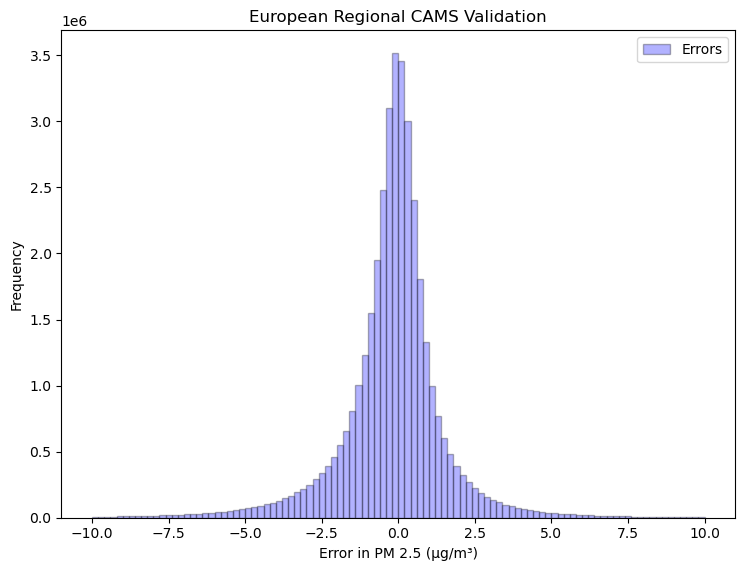

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.tight_layout(pad=3.0)

axes.hist(error_valid, bins=100, alpha=0.3, color='blue', label='Errors', edgecolor='black', range=(-10, 10))#(error_valid.min(), error_valid.max()))
#axes.set_xlim([0, 21])
#axes.set_ylim([0, 0.01])
axes.set_title('European Regional CAMS Validation')
axes.set_xlabel('Error in PM 2.5 (µg/m³)')
axes.set_ylabel('Frequency')
axes.legend()
#pdf.savefig()

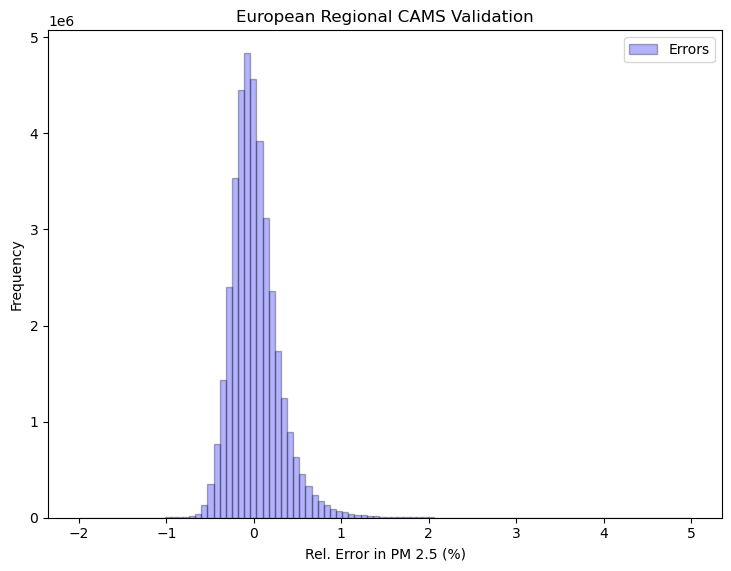

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.tight_layout(pad=3.0)

axes.hist(rel_error_valid, bins=100, alpha=0.3, color='blue', label='Errors', edgecolor='black', range=(-2, 5))#(error_valid.min(), error_valid.max()))
#axes.set_xlim([0, 21])
#axes.set_ylim([0, 0.01])
axes.set_title('European Regional CAMS Validation')
axes.set_xlabel('Rel. Error in PM 2.5 (%)')
axes.set_ylabel('Frequency')
axes.legend()
#pdf.savefig()

#### Subsample

In [14]:
# Muestreo aleatorio del 1% de los datos (ajustable)
#valid_sample_size = int(0.001 * len(error_valid))  # 1% de 181M = 1.81M
#error_valid_sample = np.random.choice(error_valid, valid_sample_size, replace=False)

error_valid_sample = error_valid


#### Histogram comparison

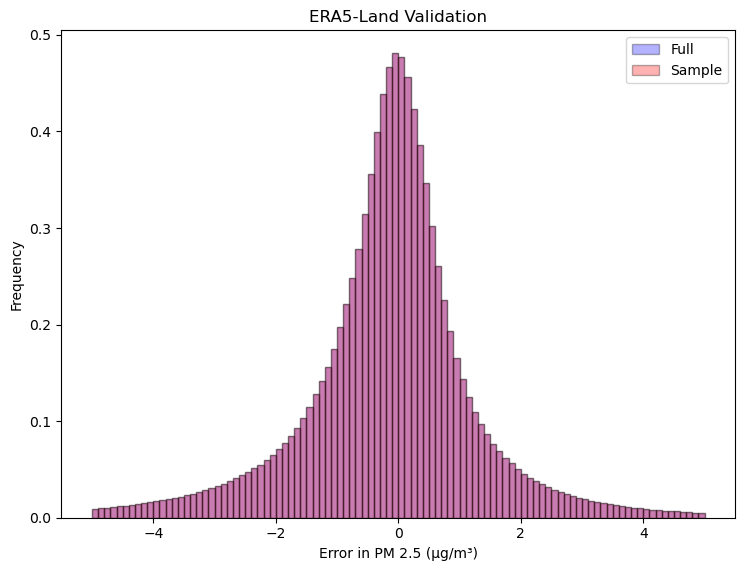

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.tight_layout(pad=3.0)

axes.hist(error_valid, bins=100, alpha=0.3, color='blue', label='Full', edgecolor='black', range=(-5, 5), density=True)#range=(error_valid.min(), error_valid.max()))
axes.hist(error_valid_sample, bins=100, alpha=0.3, color='red', label='Sample', edgecolor='black', range=(-5, 5), density=True)#range=(error_valid_sample.min(), error_valid_sample.max()))
#axes.set_xlim([0, 21])
#axes.set_ylim([0, 0.01])
axes.set_title('ERA5-Land Validation')
axes.set_xlabel('Error in PM 2.5 (µg/m³)')
axes.set_ylabel('Frequency')
axes.legend()
#pdf.savefig()

#### Fit errors to a Gaussian Kernel density

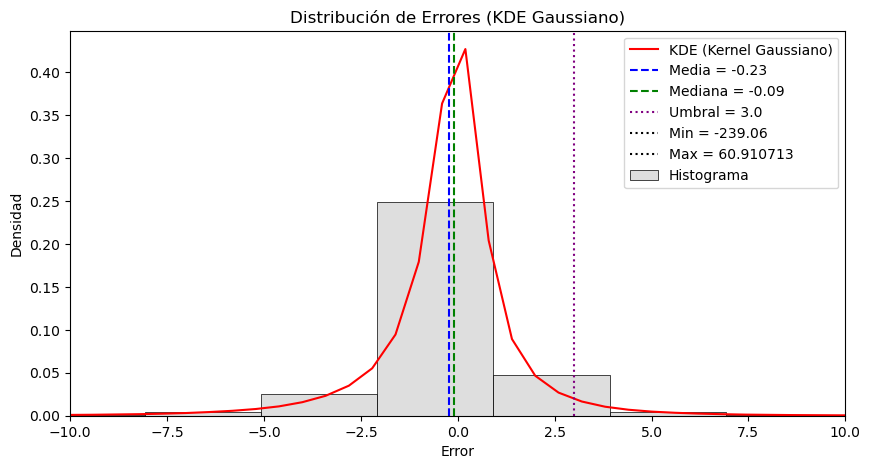

📊 Análisis de Errores:

✔ Media del error: -0.2331
✔ Desviación estándar: 2.2641
✔ Mínimum: -239.0556
✔ Maximum: 60.9107
✔ Asimetría (skewness): -10.3436 (Cola izquierda larga)
✔ Curtosis: 566.6181 (Colas largas - más outliers)
✔ Percentiles: P5=-3.15, P25=-0.81, P50=-0.09, P75=0.52, P95=2.26
✔ Probabilidad de error > 3.0: 0.0270 (2.70%)


In [16]:
from scipy.stats import gaussian_kde, skew, kurtosis

# Estadísticas básicas
mean_error = np.mean(error_valid_sample)
std_error = np.std(error_valid_sample)
min_error = np.min(error_valid_sample)
max_error = np.max(error_valid_sample)
skewness = skew(error_valid_sample)
kurt = kurtosis(error_valid_sample)

# Percentiles
p05, p25, p50, p75, p95 = np.percentile(error_valid_sample, [5, 25, 50, 75, 95])

# Fit to a density of Gaussian kernel
kde = gaussian_kde(error_valid_sample, bw_method='scott')  # También puedes probar 'silverman'

# Range of values to test the density
x_vals = np.linspace(error_valid_sample.min(), error_valid_sample.max(), 500)

# Test density
density = kde(x_vals)

# Probabilidad de errores extremos (> threshold)
threshold = 3.0  # Definir umbral de error extremo
prob_large_error = np.trapz(density[x_vals > threshold], x_vals[x_vals > threshold])

# Graficar KDE + histograma
plt.figure(figsize=(10, 5))
sns.histplot(error_valid_sample, bins=100, kde=False, stat="density", color="lightgray", label="Histograma")
plt.plot(x_vals, density, 'r-', label="KDE (Kernel Gaussiano)")
plt.xlim(-10, 10)
plt.axvline(mean_error, color='blue', linestyle='--', label=f"Media = {mean_error:.2f}")
plt.axvline(p50, color='green', linestyle='--', label=f"Mediana = {p50:.2f}")
plt.axvline(threshold, color='purple', linestyle=':', label=f"Umbral = {threshold}")
plt.axvline(min_error, color='black', linestyle=':', label=f"Min = {min_error:.2f}")
plt.axvline(max_error, color='black', linestyle=':', label=f"Max = {max_error:2f}")
plt.xlabel("Error")
plt.ylabel("Densidad")
plt.title("Distribución de Errores (KDE Gaussiano)")
plt.legend()
plt.show()

# Imprimir resultados
print(f"📊 Análisis de Errores:\n")
print(f"✔ Media del error: {mean_error:.4f}")
print(f"✔ Desviación estándar: {std_error:.4f}")
print(f"✔ Mínimum: {min_error:.4f}")
print(f"✔ Maximum: {max_error:.4f}")
print(f"✔ Asimetría (skewness): {skewness:.4f} {'(Cola derecha larga)' if skewness > 0 else '(Cola izquierda larga)' if skewness < 0 else '(Simétrica)'}")
print(f"✔ Curtosis: {kurt:.4f} {'(Colas largas - más outliers)' if kurt > 3 else '(Colas cortas - menos outliers)' if kurt < 3 else '(Distribución normal)'}")
print(f"✔ Percentiles: P5={p05:.2f}, P25={p25:.2f}, P50={p50:.2f}, P75={p75:.2f}, P95={p95:.2f}")
print(f"✔ Probabilidad de error > {threshold}: {prob_large_error:.4f} ({prob_large_error*100:.2f}%)")



#### Normal distribution

#### Valid

Mean:  -0.23310962
sigma:  2.2640722


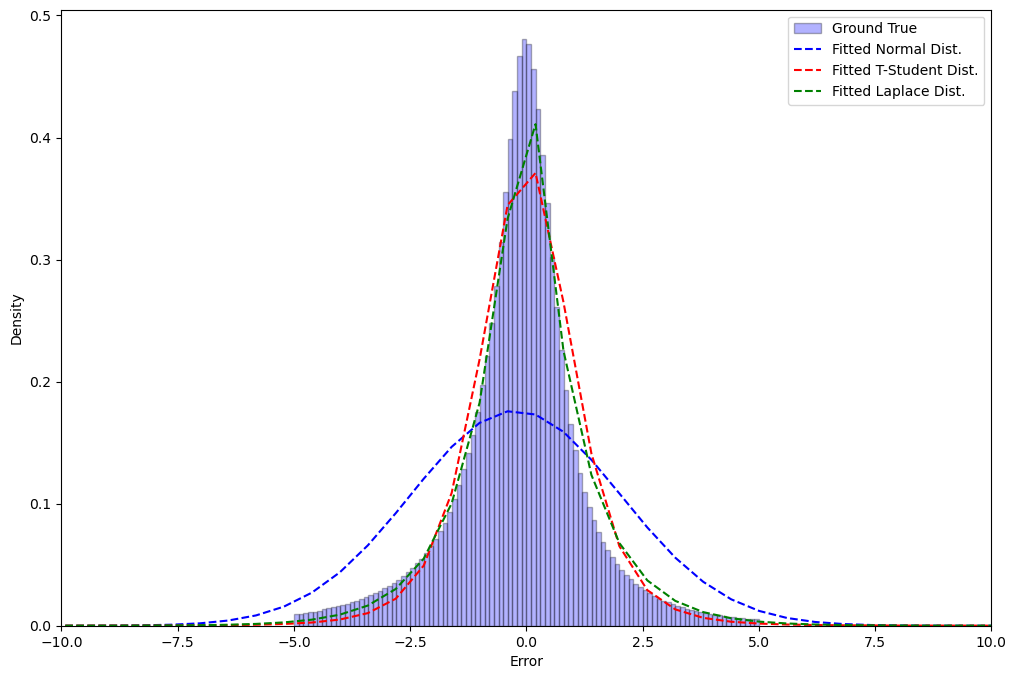

In [17]:
from scipy.stats import norm, t, laplace

# Fit a Normal distribution
mu, sigma = np.mean(error_valid.flatten()), np.std(error_valid.flatten())

print('Mean: ', mu)
print('sigma: ', sigma)

# Range of values to test the density
x_vals = np.linspace(error_valid.min(), error_valid.max(), 500)

normal_pdf = norm.pdf(x_vals, mu, sigma)
t_pdf = t.pdf(x_vals, 5)
lap_pdf = laplace.pdf(x_vals, loc=0, scale=1)

# Comparative plot
plt.figure(figsize=(12, 8))
plt.hist(error_valid, bins=100, alpha=0.3, color='blue', label='Ground True', edgecolor='black', range=(-5, 5), density=True)#range=(error_valid.min(), error_valid.max()))
#plt.plot(x_vals, density, 'r-', label='KDE (Kernel Gaussiano)')
plt.plot(x_vals, normal_pdf, 'b--', label='Fitted Normal Dist.')
plt.plot(x_vals, t_pdf, 'r--', label='Fitted T-Student Dist.')
plt.plot(x_vals, lap_pdf, 'g--', label='Fitted Laplace Dist.')
plt.xlim(-10, 10)
plt.xlabel("Error")
plt.ylabel("Density")
plt.legend()
plt.show()


In [18]:
pdf.close()

/tmp/ipykernel_825770/895159787.py:1: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  pdf.close()
